In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_ds = datasets.ImageFolder(
    root="tiny-imagenet-10/train",
    transform=transform
)

train_loader = DataLoader(
    train_ds,
    batch_size=64,
    shuffle=True
)


In [4]:
class DeepFCNN_Sigmoid(nn.Module):
    def __init__(self, depth=8, hidden=512):
        super().__init__()
        layers = []
        in_dim = 64 * 64 * 3  # 12288

        for _ in range(depth):
            layers.append(nn.Linear(in_dim, hidden))
            layers.append(nn.Sigmoid())
            in_dim = hidden

        layers.append(nn.Linear(hidden, 10))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)


In [5]:
class DeepFCNN_ReLU_BN(nn.Module):
    def __init__(self, depth=8, hidden=512):
        super().__init__()
        layers = []
        in_dim = 64 * 64 * 3

        for _ in range(depth):
            layers.append(nn.Linear(in_dim, hidden))
            layers.append(nn.BatchNorm1d(hidden))
            layers.append(nn.ReLU())
            in_dim = hidden

        layers.append(nn.Linear(hidden, 10))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)


In [6]:
def train_and_track(model, loader, epochs=3):
    model.to(device)
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    grad_norms = []

    for epoch in range(epochs):
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()

            # FIRST layer gradient norm
            first_layer_weight = model.net[0].weight
            grad_norms.append(first_layer_weight.grad.norm().item())

            optimizer.step()

    return grad_norms


In [7]:
sigmoid_model = DeepFCNN_Sigmoid()
relu_bn_model = DeepFCNN_ReLU_BN()

sigmoid_grads = train_and_track(sigmoid_model, train_loader)
relu_bn_grads = train_and_track(relu_bn_model, train_loader)


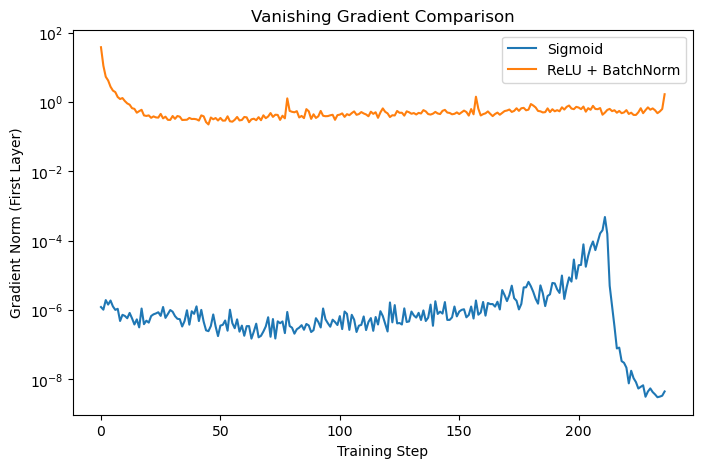

In [8]:
plt.figure(figsize=(8,5))
plt.plot(sigmoid_grads, label="Sigmoid")
plt.plot(relu_bn_grads, label="ReLU + BatchNorm")
plt.yscale("log")
plt.xlabel("Training Step")
plt.ylabel("Gradient Norm (First Layer)")
plt.legend()
plt.title("Vanishing Gradient Comparison")
plt.show()


## 3.2

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"


In [10]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_ds = datasets.ImageFolder(
    root="tiny-imagenet-10/train",
    transform=transform
)

val_ds = datasets.ImageFolder(
    root="tiny-imagenet-10/val",
    transform=transform
)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)


In [11]:
class DeepFCNN(nn.Module):
    def __init__(self, dropout=True):
        super().__init__()
        layers = []
        in_dim = 64 * 64 * 3

        for _ in range(8):
            layers.append(nn.Linear(in_dim, 512))
            layers.append(nn.BatchNorm1d(512))
            layers.append(nn.ReLU())
            if dropout:
                layers.append(nn.Dropout(0.5))
            in_dim = 512

        layers.append(nn.Linear(512, 10))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)


In [ ]:
def train_and_eval(lr, optimizer_type="adam", dropout=True, epochs=10):
    model = DeepFCNN(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_type == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    # ---- Training ----
    model.train()
    for _ in range(epochs):
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

    # ---- Validation Accuracy ----
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total


In [16]:
results = {}

# Baseline
results["Baseline (Adam, LR=1e-3, Dropout)"] = train_and_eval(
    lr=1e-3, optimizer_type="adam", dropout=True
)

# 1. Remove Dropout
results["No Dropout"] = train_and_eval(
    lr=1e-3, optimizer_type="adam", dropout=False
)

# 2a. Learning rate too high
results["High LR (1e-2)"] = train_and_eval(
    lr=1e-2, optimizer_type="adam", dropout=True
)

# 2b. Learning rate too low
results["Low LR (1e-4)"] = train_and_eval(
    lr=1e-4, optimizer_type="adam", dropout=True
)

# 3. Adam → SGD
results["SGD (LR=1e-3)"] = train_and_eval(
    lr=1e-3, optimizer_type="sgd", dropout=True
)


In [18]:
print("\nAblation Study Results\n")
for k, v in results.items():
    print(f"{k:30s}: {v*100:.2f}%")


Ablation Study Results

Baseline (Adam, LR=1e-3, Dropout): 26.60%
No Dropout                    : 32.80%
High LR (1e-2)                : 29.20%
Low LR (1e-4)                 : 10.00%
SGD (LR=1e-3)                 : 10.60%


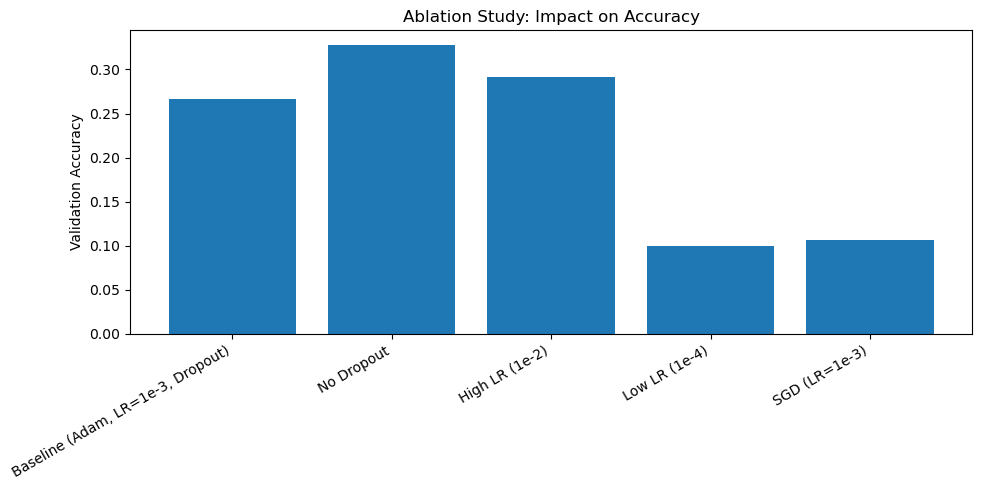

In [19]:
plt.figure(figsize=(10,5))
plt.bar(results.keys(), results.values())
plt.ylabel("Validation Accuracy")
plt.xticks(rotation=30, ha="right")
plt.title("Ablation Study: Impact on Accuracy")
plt.tight_layout()
plt.show()
